<a href="https://colab.research.google.com/github/nytrp/sistemas-inteligentes-para-electronica/blob/main/Redes_Neuronales_Recurrentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🌐 Redes Neuronales Recurrentes (RNN)**
## 👥Grupo:

### Alejandro Martinez, Yurliana Niebles, Isaac Montes, Daniel Santiago





## 1) 🧠 ¿Qué es una RNN?

Una Red Neuronal Recurrente (RNN) es una arquitectura de Deep Learning cuya estructura es muy similar a la de una red neuronal convencional, pero diseñada para procesar secuencias; es decir, datos que cambian con el tiempo (videos, conversaciones, texto, series temporales).

El concepto central que da nombre a estas redes es la recurrencia. A diferencia de redes feedforward o convolucionales que consideran solo la entrada actual para generar una salida, las redes recurrentes tienen memoria: guardan información pasada mediante un estado oculto (activación). Esa activación permite que la salida en un instante dependa de entradas previas, por eso las RNN son ideales para secuencias.



## 2) ⚙️¿Cómo funciona? Arquitectura y flujo de datos

### RNN
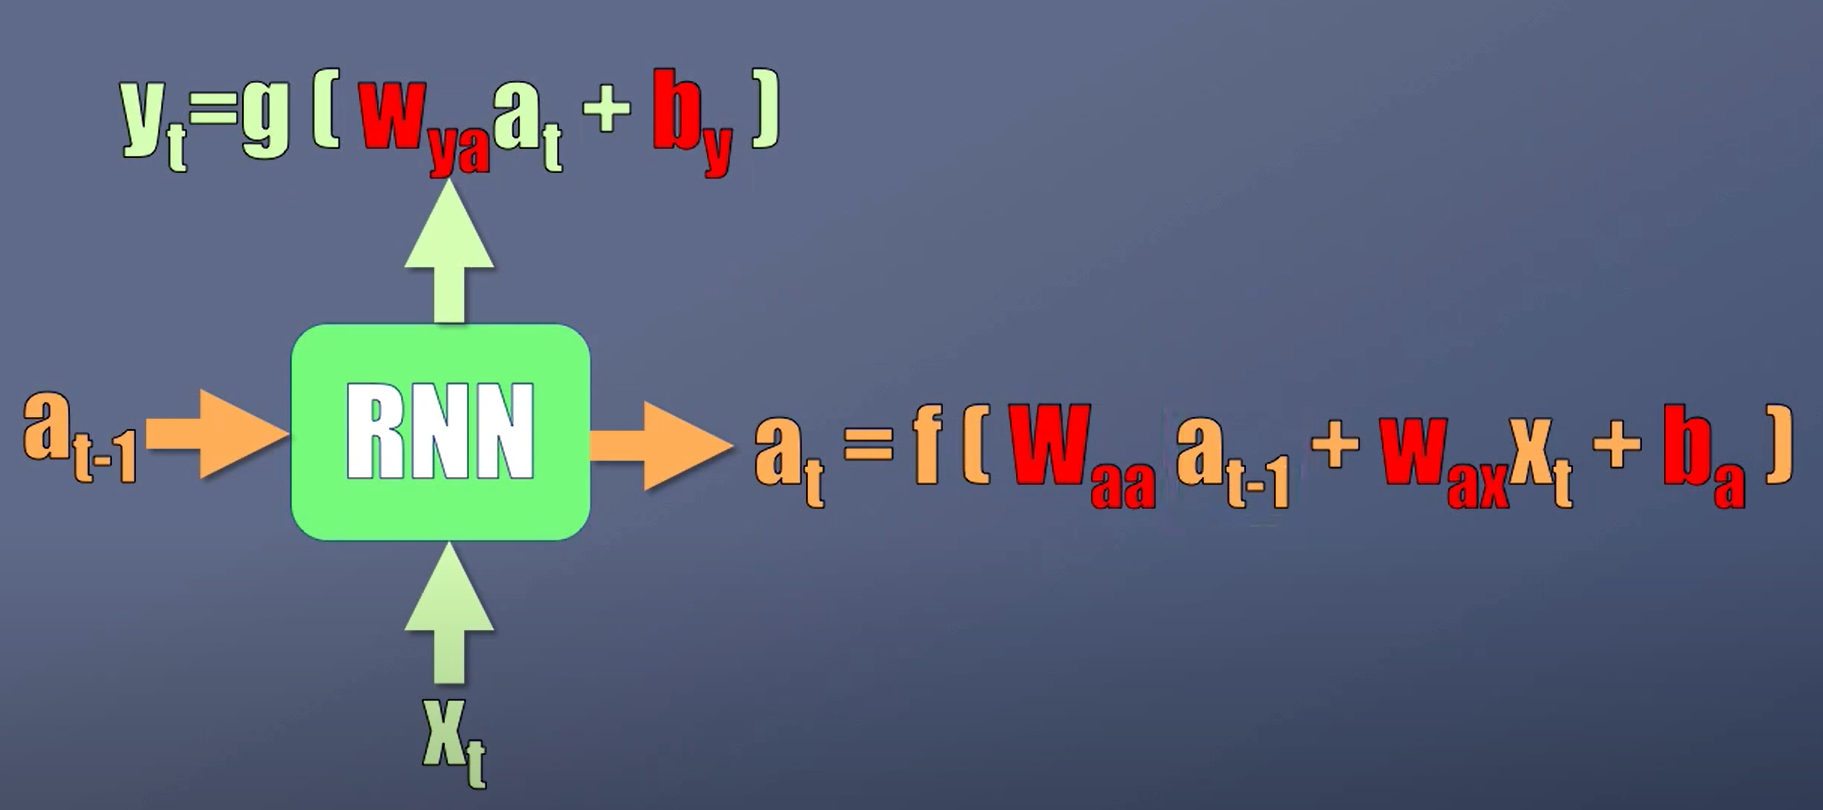
En cada paso temporal t la RNN calcula:

$$
a_t = \phi\big(W_{aa} a_{t-1} + W_{xa} x_t + b_a\big)
$$
$$
y_t = g\big(W_{ay} a_t + b_y\big)
$$

Donde:
- $x_t$: entrada en el tiempo t.
- $a_t$: activación / estado oculto en t (memoria).
- $a_{t-1}$: activación en t-1.
- $y_t$: salida (predicción) en t.
- $W_{xa}, W_{aa}, W_{ay}$ matrices de pesos compartidos; $b_a, b_y$ sesgos.
- $\phi$ es una función no lineal (tanh o ReLU), $g$ depende de la tarea (lineal para regresión).

### Flujo de datos
1. Recibe la entrada actual $x_t$ y la activación previa $a_{t-1}$.
2. Calcula la nueva activación $a_t$ combinando $x_t$ y $a_{t-1}$ con pesos compartidos.
3. Opcionalmente produce una salida $y_t$ a partir de $a_t$ (o usa $a_T$ final para clasificar la secuencia completa).



## 3) 🔁 LSTM (Long Short-Term Memory) — Fórmulas y explicación

LSTM añade una celda de memoria $c_t$ y compuertas que controlan flujo de información.

Ecuaciones estándar:

$$
f_t = \sigma(W_f [x_t, a_{t-1}] + b_f) \quad\text{(puerta de olvido)}
$$

$$
i_t = \sigma(W_i [x_t, a_{t-1}] + b_i) \quad\text{(puerta de entrada)}
$$

$$
\tilde{c}_t = \tanh(W_c [x_t, a_{t-1}] + b_c) \quad\text{(candidato a celda)}
$$

$$
c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \quad\text{(actualización de la celda)}
$$

$$
o_t = \sigma(W_o [x_t, a_{t-1}] + b_o) \quad\text{(puerta de salida)}
$$

$$
a_t = o_t \odot \tanh(c_t) \quad\text{(estado oculto)}
$$

Explicación breve:
- $f_t$ decide qué olvidar de $c_{t-1}$.
- $i_t$ regula cuánto del candidato $\tilde{c}_t$ entra.
- $o_t$ controla qué parte de $c_t$ se expone en la salida.



## 4)🧪 GRU — versión compacta

GRU simplifica LSTM combinando puertas:

$$
z_t = \sigma(W_z [x_t, a_{t-1}]) \quad\text{(update gate)}
$$

$$
r_t = \sigma(W_r [x_t, a_{t-1}]) \quad\text{(reset gate)}
$$

$$
\tilde{a}_t = \tanh(W [x_t, r_t \odot a_{t-1}])
$$

$$
a_t = (1 - z_t) \odot a_{t-1} + z_t \odot \tilde{a}_t
$$

Menos parámetros que LSTM; rendimiento similar en muchas tareas.

## 5) 🎯¿Para qué sirve?

Las RNN son adecuadas siempre que los datos formen una secuencia. Aplicaciones típicas:

- Procesamiento de lenguaje natural: análisis de sentimiento, generación de texto, traducción (antes de transformers).
- Reconocimiento y síntesis de voz.
- Series temporales: forecasting (consumo, demanda, sensórica).
- Etiquetado secuencial (NER, POS tagging).
- Generación de secuencias (música, nombres, secuencias biológicas).
- Análisis y generación de video (secuencia de frames).




## 6) 📊 Ventajas y desventajas

✅**Ventajas**
- Memoria temporal explícita (estado oculto).
- Adaptadas a secuencias de longitud variable.
- LSTM/GRU manejan dependencias largas mejor que RNN vanilla.

❌**Desventajas**
- BPTT costoso y con problemas numéricos (gradientes).
- Menos paralelizables que Transformers → entrenamiento más lento.
- Para muchas tareas NLP modernas, Transformers superan a RNNs.
- Requieren más datos/ajuste que modelos simples en datasets pequeños.

Celda 1 — Importar librerías

In [ ]:
# Celda 1 — Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


Celda 2 — Cargar dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB
None
            Passengers
Month                 
1949-01-01       112.0
1949-02-01       118.0
1949-03-01       132.0
1949-04-01       129.0
1949-05-01       121.0


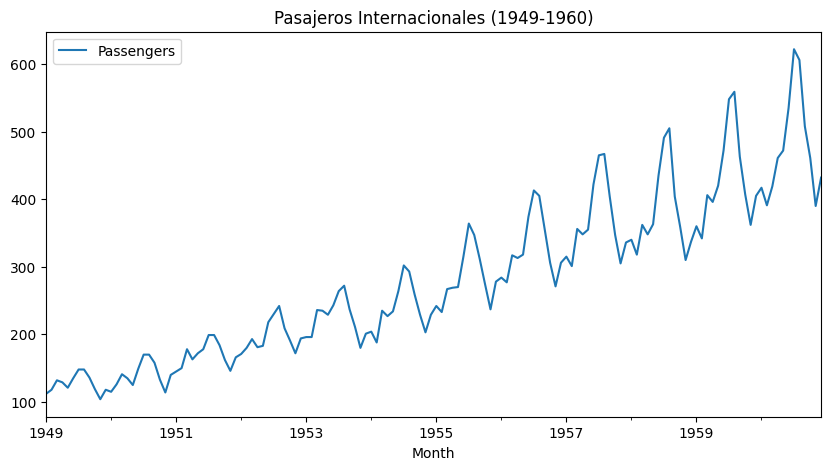

In [ ]:
# Celda 2 corregida — Cargar dataset
df = pd.read_csv("international-airline-passengers.csv")

# Renombrar columnas (la segunda columna tiene un nombre muy largo)
df.columns = ["Month", "Passengers"]

# Quitar filas con valores no numéricos en 'Passengers'
df = df[pd.to_numeric(df["Passengers"], errors="coerce").notnull()]

# Convertir a tipo numérico
df["Passengers"] = df["Passengers"].astype(float)

# Convertir 'Month' a fecha
df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m")

# Usar 'Month' como índice
df.set_index("Month", inplace=True)

# Mostrar
print(df.info())
print(df.head())

# Gráfico
df.plot(y="Passengers", figsize=(10,5), title="Pasajeros Internacionales (1949-1960)")
plt.show()


Celda 3 — Preprocesamiento y ventanas

In [ ]:
# Escalar datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df["Passengers"].values.reshape(-1,1))

# Crear ventanas (lags)
def create_windows(data, window=12):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

WINDOW = 12
X, y = create_windows(scaled, WINDOW)

# Dividir train/test (70/30)
split = int(len(X)*0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Redimensionar para LSTM [samples, timesteps, features]
X_train_l = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_l = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


Celda 4 — Modelo LSTM (RNN mejorada)

In [ ]:
# Modelo LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(WINDOW,1)),
    Dropout(0.1),
    LSTM(64, return_sequences=False),
    Dropout(0.1),
    Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train_l, y_train, epochs=300, batch_size=8,
                    validation_data=(X_test_l, y_test), verbose=1)


Epoch 1/300


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0535 - val_loss: 0.0231
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0081 - val_loss: 0.0213
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0060 - val_loss: 0.0204
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0072 - val_loss: 0.0214
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0048 - val_loss: 0.0229
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0058 - val_loss: 0.0196
Epoch 7/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0076 - val_loss: 0.0193
Epoch 8/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0063 - val_loss: 0.0191
Epoch 9/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0056 - val_loss: 0.0204
Epoch 10/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0065 - val_loss: 0.0185
Epoch 11/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050 - val_loss: 0.0253
Epoch 12/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

Celda 5 — Evaluación del LSTM

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
LSTM RMSE: 27.403994292226272
LSTM R2: 0.8792239877920536


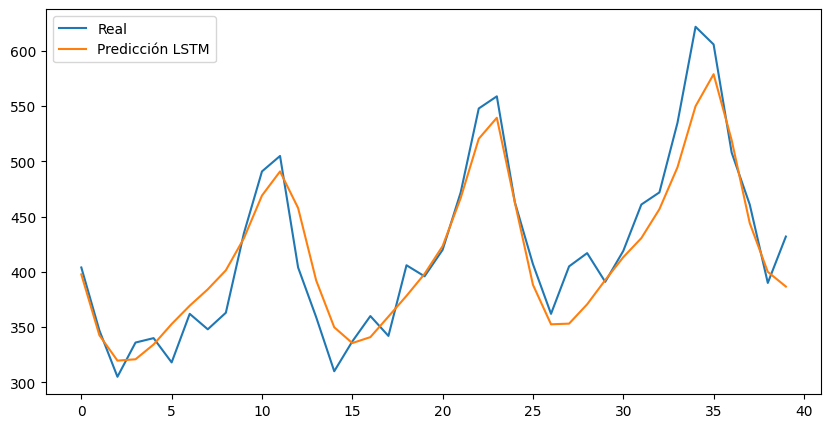

In [ ]:
# Predicciones
y_pred_lstm = model.predict(X_test_l)

# Desescalar
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

# Métricas
rmse_lstm = sqrt(mean_squared_error(y_test_inv, y_pred_lstm))
r2_lstm = r2_score(y_test_inv, y_pred_lstm)

print("LSTM RMSE:", rmse_lstm)
print("LSTM R2:", r2_lstm)

# Gráfico
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Real")
plt.plot(y_pred_lstm, label="Predicción LSTM")
plt.legend()
plt.show()


Celda 6 — Comparación con modelos clásicos

LR RMSE: 21.46714966779127
LR R2: 0.9258857501033338
RF RMSE: 57.11627728808994
RF R2: 0.4753463049905169


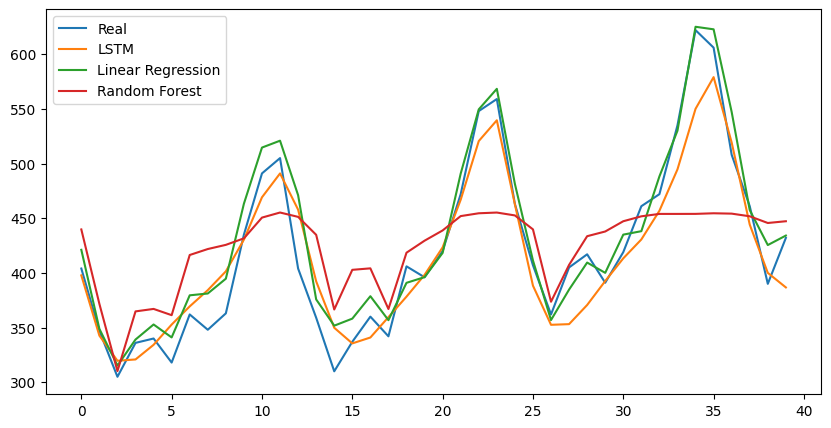

In [ ]:
# Aplanar ventanas para modelos clásicos
X_train_c = X_train.reshape(X_train.shape[0], -1)
X_test_c = X_test.reshape(X_test.shape[0], -1)

# ===== Regresión Lineal =====
lr = LinearRegression()
lr.fit(X_train_c, y_train)
y_pred_lr = scaler.inverse_transform(lr.predict(X_test_c).reshape(-1,1))

print("LR RMSE:", sqrt(mean_squared_error(y_test_inv, y_pred_lr)))
print("LR R2:", r2_score(y_test_inv, y_pred_lr))

# ===== Random Forest =====
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_c, y_train.ravel())
y_pred_rf = scaler.inverse_transform(rf.predict(X_test_c).reshape(-1,1))

print("RF RMSE:", sqrt(mean_squared_error(y_test_inv, y_pred_rf)))
print("RF R2:", r2_score(y_test_inv, y_pred_rf))

# ===== Gráfico comparativo =====
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Real")
plt.plot(y_pred_lstm, label="LSTM")
plt.plot(y_pred_lr, label="Linear Regression")
plt.plot(y_pred_rf, label="Random Forest")
plt.legend()
plt.show()
